In [ ]:
import requests
import xmltodict
import pandas as pd

def fetch_arxiv_papers(query="all", max_results=50):
    """
    Fetches papers from arXiv based on a query.
    
    Args:
        query (str): Search term or category.
        max_results (int): Number of papers to retrieve.
        
    Returns:
        DataFrame: Contains titles, abstracts, and arXiv IDs.
    """
    base_url = "http://export.arxiv.org/api/query?"
    url = f"{base_url}search_query={query}&start=0&max_results={max_results}"

    response = requests.get(url)
    if response.status_code != 200:
        raise Exception(f"Error: Unable to fetch data (Status: {response.status_code})")

    data = xmltodict.parse(response.content)
    if 'entry' not in data['feed']:
        return pd.DataFrame()
    entries = data['feed']['entry']
    
    # Parse entries into a DataFrame
    papers = []
    for entry in entries:
        papers.append({
            "id": entry["id"],
            "title": entry["title"].strip(),
            "summary": entry["summary"].strip(),
            "published": entry["published"],
            "category": entry["arxiv:primary_category"]["@term"],
            "query": query
        })

    return pd.DataFrame(papers)

# Example Usage

queries = ['machine learning', '3D computer vision', 'DNA', 'Nuclear Theory'] 

df = pd.DataFrame()

for query in queries: 
    papers_df = fetch_arxiv_papers(query=query, max_results=15)
    df = pd.concat([df, papers_df], ignore_index=True)
print(df.head())


                                  id  \
0  http://arxiv.org/abs/1909.03550v1   
1  http://arxiv.org/abs/1811.04422v1   
2  http://arxiv.org/abs/1707.04849v1   
3  http://arxiv.org/abs/1909.09246v1   
4  http://arxiv.org/abs/2301.09753v1   

                                               title  \
0   Lecture Notes: Optimization for Machine Learning   
1  An Optimal Control View of Adversarial Machine...   
2  Minimax deviation strategies for machine learn...   
3  Machine Learning for Clinical Predictive Analy...   
4  Towards Modular Machine Learning Solution Deve...   

                                             summary             published  \
0  Lecture notes on optimization for machine lear...  2019-09-08T21:49:42Z   
1  I describe an optimal control view of adversar...  2018-11-11T14:28:34Z   
2  The article is devoted to the problem of small...  2017-07-16T09:15:08Z   
3  In this chapter, we provide a brief overview o...  2019-09-19T22:02:00Z   
4  Machine learning technologies

In [14]:
queries = ['sentiment analysis', 'black holes', 'hydropower'] 

for query in queries: 
    papers_df = fetch_arxiv_papers(query=query, max_results=15)
    df = pd.concat([df, papers_df], ignore_index=True)
print(df.head())

                                  id  \
0  http://arxiv.org/abs/1909.03550v1   
1  http://arxiv.org/abs/1811.04422v1   
2  http://arxiv.org/abs/1707.04849v1   
3  http://arxiv.org/abs/1909.09246v1   
4  http://arxiv.org/abs/2301.09753v1   

                                               title  \
0   Lecture Notes: Optimization for Machine Learning   
1  An Optimal Control View of Adversarial Machine...   
2  Minimax deviation strategies for machine learn...   
3  Machine Learning for Clinical Predictive Analy...   
4  Towards Modular Machine Learning Solution Deve...   

                                             summary             published  \
0  Lecture notes on optimization for machine lear...  2019-09-08T21:49:42Z   
1  I describe an optimal control view of adversar...  2018-11-11T14:28:34Z   
2  The article is devoted to the problem of small...  2017-07-16T09:15:08Z   
3  In this chapter, we provide a brief overview o...  2019-09-19T22:02:00Z   
4  Machine learning technologies

In [2]:
def get_paper_citations(arxiv_id):
    """
    Fetches the citation count for a paper from Semantic Scholar using the arXiv ID.
    
    Args:
        arxiv_id (str): The arXiv ID of the paper (e.g., "2103.00020").
        
    Returns:
        int: Citation count, or None if not found.
    """
    url = f"https://api.semanticscholar.org/v1/paper/arXiv:{arxiv_id}"
    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        return data.get("numCitedBy", 0)
    else:
        return None

# Example usage
arxiv_id = "1706.03762"  # Replace with a valid arXiv ID
citation_count = get_paper_citations(arxiv_id)
print(f"Paper {arxiv_id} has {citation_count} citations.")


Paper 1706.03762 has 112066 citations.


In [15]:
from sentence_transformers import SentenceTransformer
import numpy as np

# Load Sentence-BERT model
model = SentenceTransformer('all-MiniLM-L6-v2')  # Small, fast model for semantic embeddings

# Prepare the text: combine titles and abstracts
df['text'] = df['title'] + ". " + df['summary']

# Generate embeddings
embeddings = model.encode(df['text'].tolist(), show_progress_bar=True)

# Save embeddings as a NumPy array
embeddings = np.array(embeddings)
print(f"Generated embeddings shape: {embeddings.shape}")

Batches: 100%|██████████| 4/4 [00:01<00:00,  3.26it/s]

Generated embeddings shape: (105, 384)


In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer

# Standardize the embeddings before PCA (important for better results)
scaler = StandardScaler()
embeddings_scaled = scaler.fit_transform(embeddings)

# Perform PCA to reduce to 2D or 3D
pca = PCA(n_components=2)  # For 2D visualization, change to 3 for 3D
pca_result = pca.fit_transform(embeddings_scaled)

# Add the PCA results to your DataFrame for easier visualization
df['PCA_x'] = pca_result[:, 0]
df['PCA_y'] = pca_result[:, 1]

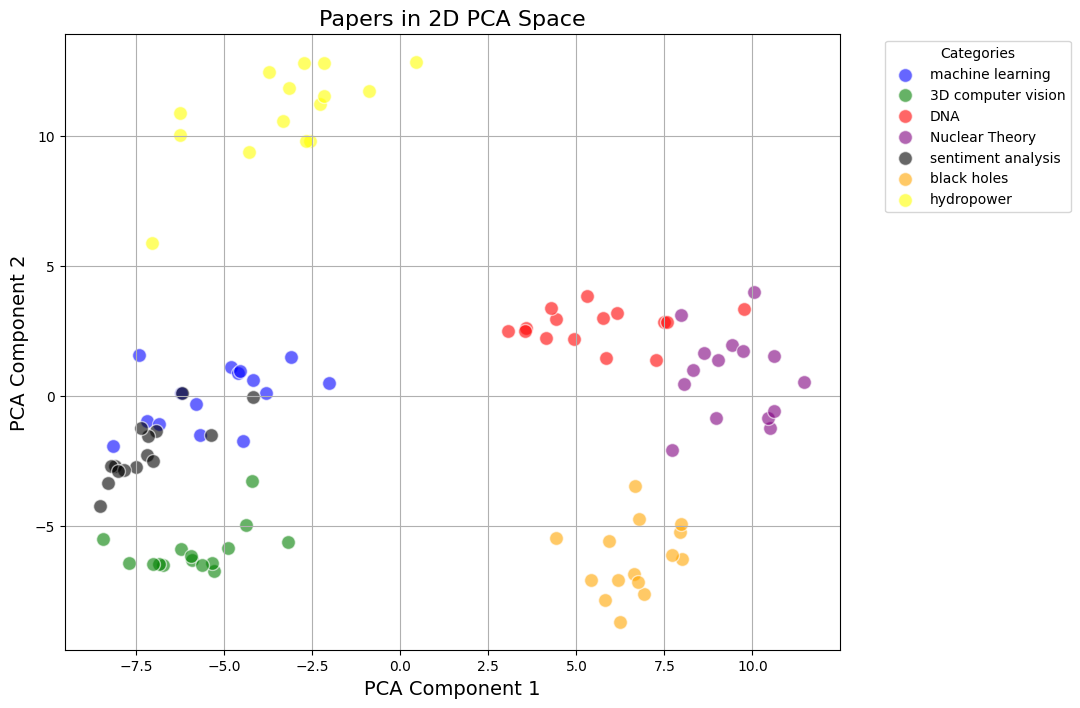

In [17]:
# Define a color map based on categories
category_colors = {
    'machine learning': 'blue',
    '3D computer vision': 'green',
    'DNA': 'red',
    'Nuclear Theory': 'purple',
    'sentiment analysis': 'black',
    'black holes': 'orange', 
    'hydropower': 'yellow'
}

# Plot the papers on a 2D scatter plot
plt.figure(figsize=(10, 8))
for category in df['query'].unique():
    category_data = df[df['query'] == category]
    plt.scatter(category_data['PCA_x'], category_data['PCA_y'], 
                label=category, color=category_colors.get(category, 'gray'), alpha=0.6, edgecolors='w', s=100)

# Add labels and title
plt.title("Papers in 2D PCA Space", fontsize=16)
plt.xlabel("PCA Component 1", fontsize=14)
plt.ylabel("PCA Component 2", fontsize=14)
plt.legend(title="Categories", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.show()


In [21]:
from sklearn.metrics.pairwise import cosine_similarity

def search_papers(query, model, embeddings, metadata, top_k=5):
    """
    Search for similar papers using cosine similarity.
    
    Args:
        query (str): Search query text.
        model: Sentence-BERT model for embeddings.
        embeddings: Precomputed paper embeddings.
        metadata: Paper metadata DataFrame.
        top_k (int): Number of top results to return.
    """
    # Encode the query into the same space
    query_embedding = model.encode([query])
    
    # Compute cosine similarity
    similarities = cosine_similarity(query_embedding, embeddings)[0]
    top_indices = similarities.argsort()[-top_k:][::-1]
    
    # Display top results
    print("Top relevant papers:\n")
    for idx in top_indices:
        print(f"Title: {metadata.iloc[idx]['title']}")
        print(f"Abstract: {metadata.iloc[idx]['summary'][:300]}...")
        print(f"Published: {metadata.iloc[idx]['published']}")
        print("-" * 80)

# Example Query
query = "nuclear networks"
search_papers(query, model, embeddings, df, top_k=3)


Top relevant papers:

Title: An Outlook on Nuclear Physics
Abstract: A brief outlook on low-energy nuclear physics is presented. Selected recent
developments in nuclear structure theory are highlighted and a few open
questions are discussed....
Published: 2013-01-05T15:31:08Z
--------------------------------------------------------------------------------
Title: Nuclear Matter and Nuclear Dynamics
Abstract: Highlights on the recent research activity, carried out by the Italian
Community involved in the "Nuclear Matter and Nuclear Dynamics" field, will be
presented....
Published: 2009-02-26T12:00:11Z
--------------------------------------------------------------------------------
Title: From the liquid drop model to lattice QCD
Abstract: The present article aims to give a concise account of the main developments
in nuclear structure theory, from its origin in the 1930s to date, taking the
modelling of inter-nucleon interactions as guideline....
Published: 2018-11-09T15:45:36Z
----------

In [22]:
import requests
import xmltodict

# Define the search query (e.g., "DNA sequencing")
query = "DNA sequencing"
max_results = 100  # Number of results to fetch

# Define the URL for Esearch API (search PubMed)
url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi?db=pubmed&term={query}&retmax={max_results}&retmode=xml"

# Send request to PubMed
response = requests.get(url)

# Parse the XML response
search_results = xmltodict.parse(response.content)

# Extract list of PubMed IDs (PMIDs) from the response
pmids = search_results['eSearchResult']['IdList']['Id']
print(f"Found {len(pmids)} articles related to '{query}'")


Found 100 articles related to 'DNA sequencing'


In [27]:
pmids[0]

'39688736'

In [32]:
# Define a function to fetch details of papers from PubMed
def fetch_paper_details(pmids):
    pmid_str = ",".join(pmids)  # Join PMIDs into a comma-separated string
    
    # Define the URL for Efetch API (fetch details by PMIDs)
    url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi?db=pubmed&id={pmid_str}&retmode=xml"
    
    # Send request to PubMed
    response = requests.get(url)
    
    # Parse the XML response
    papers = xmltodict.parse(response.content)['PubmedArticleSet']['PubmedArticle']
    
    # Extract relevant information (title, abstract, authors, etc.)
    paper_details = []
    for paper in papers:
        title = paper['MedlineCitation']['Article']['ArticleTitle']
        abstract = paper['MedlineCitation']['Article'].get('Abstract', {}).get('AbstractText', '')
        authors = paper['MedlineCitation']['Article']['AuthorList']['Author']
        publication_date = paper['MedlineCitation']['Article']['Journal']['JournalIssue']['PubDate']
        
        # Collect data in a dictionary
        paper_details.append({
            "title": title,
            "abstract": extract_abstract_text(abstract),
            "authors": [author['LastName'] + " " + author['ForeName'] for author in authors],
            "publication_date": publication_date
        })
    
    return paper_details

# Fetch details for the papers using their PMIDs
papers_data = fetch_paper_details(pmids)
print(f"Fetched details for {len(papers_data)} papers")

AttributeError: 'str' object has no attribute 'get'

In [30]:
def extract_abstract_text(abstract_data):
    """
    Given the abstract data in the format with nested labels, extract just the text content.
    """
    # Extract text content from the 'text' field (i.e., '#text' key)
    
    if type(abstract_data) == str:
        return abstract_data
    
    abstract_text = []
    for section in abstract_data:
        # Extract only the text content, ignoring metadata
        abstract_text.append(section.get('#text', ''))  # Default to empty string if '#text' is missing
    
    # Combine the text from all sections
    return ' '.join(abstract_text)


In [40]:
type(papers_data[1]['abstract'])

str